#1-1

MNIST 데이터셋을 사용하여 간단한 GAN을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image


In [ ]:
num_epochs = 100
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
dir_name = "GAN_results"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

MNIST_dataset = datasets.MNIST(root='../../data/',
                               train=True,
                               transform=transform,
                               download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12820795.40it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346819.40it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 532694.35it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1398511.88it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [ ]:
class Discriminator(nn.Module): # Discriminator: 제시된 데이터가 생성된 분포인지 아닌지 확인
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module): # Generator: 실제 데이터의 분포를 근사
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_labels = torch.ones(batch_size, 1).to(device) # 실제 데이터를 나타내는 라벨(1)
        fake_labels = torch.zeros(batch_size, 1).to(device) # 생성된 가짜 데이터를 나타내는 라벨(0)

        real_images = images.reshape(batch_size, -1).to(device)

        g_optimizer.zero_grad() # 생성자 기울기 초기화

        z = torch.randn(batch_size, noise_size).to(device) # 가우시안 분포 노이즈 생성 - 이걸 입력으로 fake data 생성
        fake_images = generator(z) # 가짜 데이터 생성

        g_loss = criterion(discriminator(fake_images), real_labels) # 판별자로 가짜 데이터 평가, 손실 계산
        g_loss.backward()
        g_optimizer.step() # 생성자 파라미터 업데이트

        d_optimizer.zero_grad() # 판별자 기울기 초기화

        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        real_loss = criterion(discriminator(real_images), real_labels) # 진짜 데이터 입력, 손실 계산
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels) # 가짜 데이터 입력, 손실 계산
        d_loss = (real_loss + fake_loss) / 2 # 두 손실의 평균 = 판별자의 손실

        d_loss.backward()
        d_optimizer.step() # 판별자 파라미터 업데이트

        if (i + 1) % 150 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    save_image(fake_images.view(batch_size, 1, 28, 28),
               os.path.join(dir_name, f'GAN_fake_image_{epoch + 1}.png'))

    d_performance = discriminator(real_images).mean().item()
    g_performance = discriminator(fake_images).mean().item()
    print(f"---------Epoch [{epoch + 1}/{num_epochs}] : D Performance: {d_performance:.2f}, G Performance: {g_performance:.2f}")

Epoch [1/100], Step [150/600], D Loss: 0.0285, G Loss: 3.4373
Epoch [1/100], Step [300/600], D Loss: 0.0528, G Loss: 16.1580
Epoch [1/100], Step [450/600], D Loss: 0.0575, G Loss: 21.9043
Epoch [1/100], Step [600/600], D Loss: 0.4450, G Loss: 6.8812
---------Epoch [1/100] : D Performance: 0.86, G Performance: 0.01
Epoch [2/100], Step [150/600], D Loss: 0.0348, G Loss: 6.6455
Epoch [2/100], Step [300/600], D Loss: 0.0056, G Loss: 10.4914
Epoch [2/100], Step [450/600], D Loss: 0.2573, G Loss: 11.1086
Epoch [2/100], Step [600/600], D Loss: 0.1204, G Loss: 3.4265
---------Epoch [2/100] : D Performance: 0.94, G Performance: 0.03
Epoch [3/100], Step [150/600], D Loss: 0.1825, G Loss: 6.4570
Epoch [3/100], Step [300/600], D Loss: 0.5771, G Loss: 1.7831
Epoch [3/100], Step [450/600], D Loss: 0.0338, G Loss: 5.0604
Epoch [3/100], Step [600/600], D Loss: 0.2195, G Loss: 1.7408
---------Epoch [3/100] : D Performance: 0.87, G Performance: 0.19
Epoch [4/100], Step [150/600], D Loss: 0.2783, G Loss:

#1-2

아래 마크다운으로 GAN_fake_image_1.png와 GAN_fake_image_100.png를 함께 첨부해주세요.

**GAN_fake_image_1**

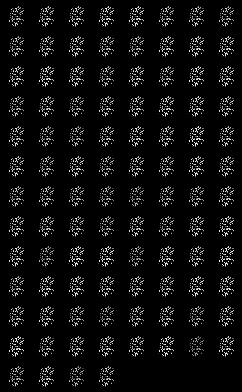

**GAN_fake_image_100**

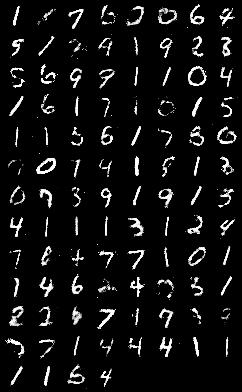